In [3]:
# ============================================================
# 1. Imports
# ============================================================
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest  # para detectar anomalias reais

sns.set(style="whitegrid")

# ============================================================
# 2. Carregar SEU dataset
# ============================================================
df = pd.read_csv("/content/Transações correntes - mensal - saldo.22701 1.csv", sep=';')

# ============================================================
# 3. Preparação e criação de atributos
# ============================================================

# Limpar e converter a coluna 'valor'
# Remover as aspas duplas, espaços e substituir vírgulas por pontos antes de converter para numérico
df["valor"] = df["valor"].astype(str).str.replace('"', '').str.replace(' ', '').str.replace(',', '.', regex=False).astype(float)

# Converter datas
df["data"] = pd.to_datetime(df["data"], format="%d/%m/%Y")

# Criar atributos derivados
df["ano"] = df["data"].dt.year
df["mes"] = df["data"].dt.month
df["variação_mensal"] = df["valor"].diff()
df["variação_abs"] = df["valor"].diff().abs()
df["tendencia"] = np.arange(len(df))

# Remover primeira linha (tem diff = NaN)
df = df.dropna()

# Seleção de features numéricas
X = df[["valor", "variação_mensal", "variação_abs", "tendencia"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================
# 4. Detectar anomalias reais usando Isolation Forest
# ============================================================
modelo = IsolationForest(contamination=0.05, random_state=42)
df["anomalia"] = modelo.fit_predict(X_scaled)

# Isolation Forest retorna:
#  1  = normal
# -1  = anomalia
df["fraude"] = (df["anomalia"] == -1).astype(int)

# ============================================================
# 5. Clusterização com K-Means
# ============================================================
kmeans = KMeans(n_clusters=2, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Score de risco baseado nas duas análises
df["score_risco"] = (df["fraude"] * 0.7) + (df["cluster"] * 0.3)



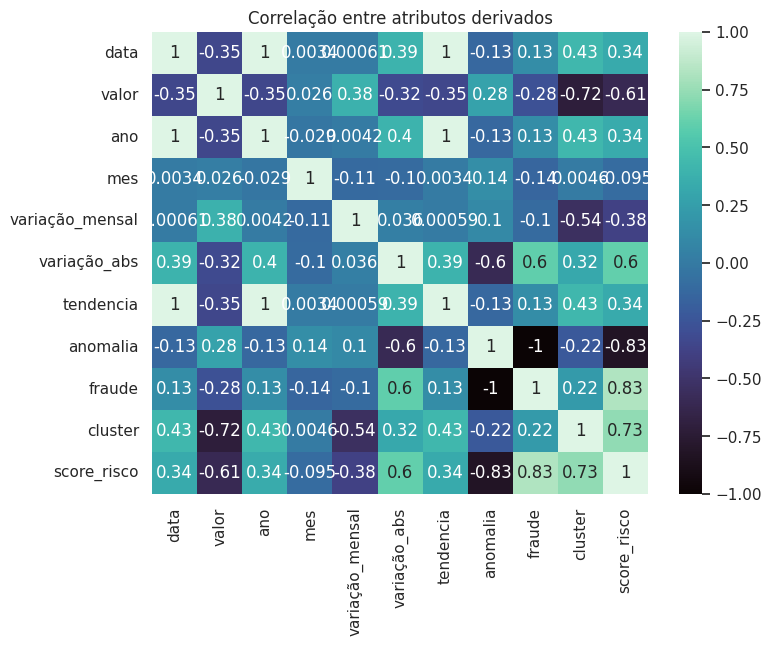

In [4]:
# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="mako")
plt.title("Correlação entre atributos derivados")
plt.show()


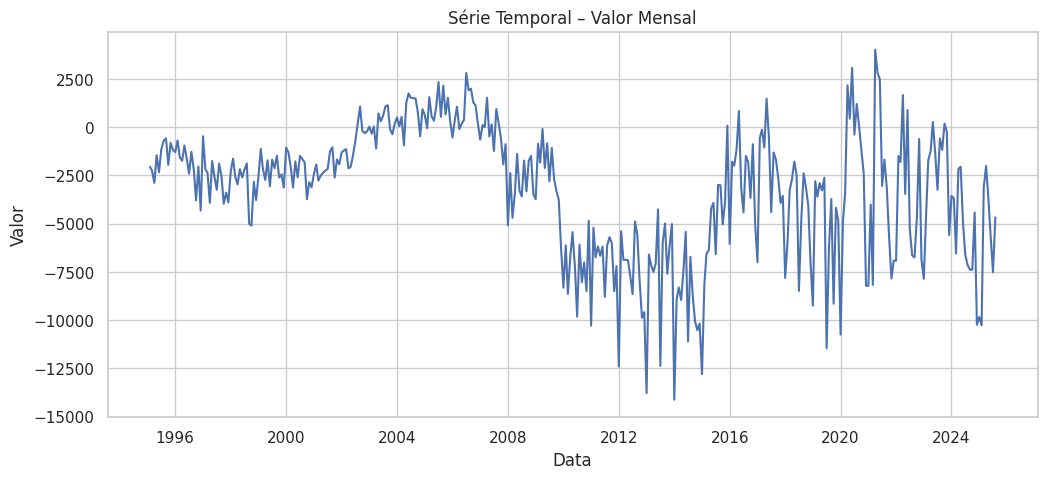

In [5]:
# Série temporal do valor
plt.figure(figsize=(12,5))
plt.plot(df["data"], df["valor"])
plt.title("Série Temporal – Valor Mensal")
plt.xlabel("Data")
plt.ylabel("Valor")
plt.show()

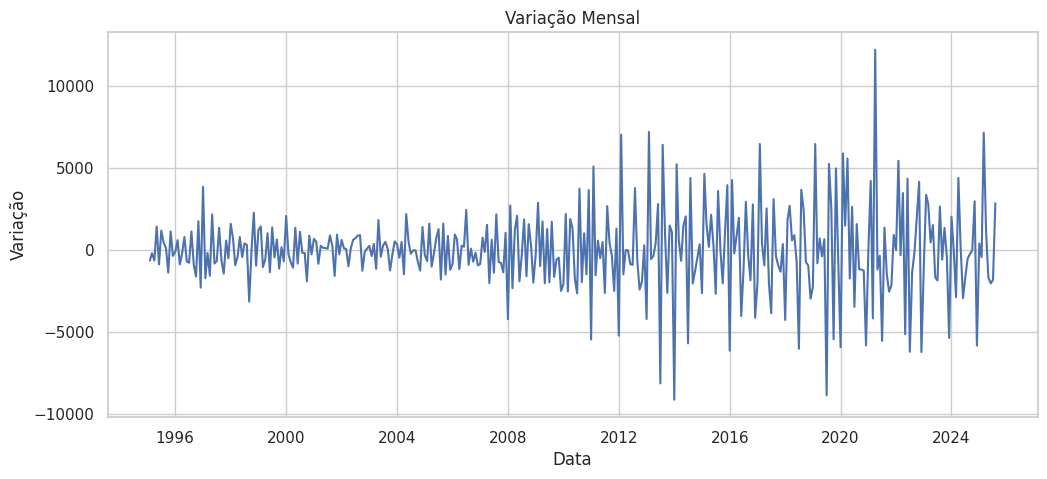

In [6]:
# Variação mensal
plt.figure(figsize=(12,5))
plt.plot(df["data"], df["variação_mensal"])
plt.title("Variação Mensal")
plt.xlabel("Data")
plt.ylabel("Variação")
plt.show()

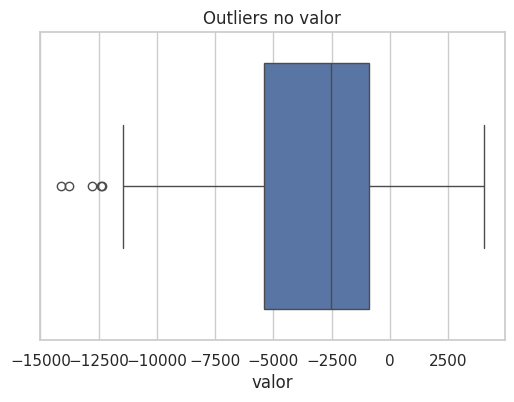

In [7]:
# Boxplot de Outliers
plt.figure(figsize=(6,4))
sns.boxplot(x=df["valor"])
plt.title("Outliers no valor")
plt.show()

In [8]:
# Distribuição do score de risco
fig1 = px.histogram(df, x="score_risco", nbins=50, color="fraude",
                    title="Distribuição do Score de Risco")
fig1.show()

In [9]:
# Dispersão valor x variação
fig2 = px.scatter(df, x="valor", y="variação_mensal",
                  color="score_risco", title="Valor vs Variação Mensal",
                  hover_data=["data"])
fig2.show()

In [10]:
# Clusters K-Means
fig3 = px.scatter(df, x="tendencia", y="valor",
                  color=df["cluster"].astype(str),
                  title="Clusters de Comportamento Mensal")
fig3.show()

In [11]:
# Fraudes ao longo do tempo
fig4 = px.scatter(df, x="data", y="valor",
                  color=df["fraude"].astype(str),
                  title="Detecção de Anomalias ao Longo do Tempo")
fig4.show()